# Various tests for pipeline checks

## Install HMM library and restart kernel

In [ ]:
!pip3 install --upgrade --user hmmlearn

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Import variables


In [1]:
import sys
import os
import io
import logging
import joblib
from google.cloud import bigquery
from google.cloud import storage
from google.colab import files

from google.cloud import bigquery
from dask import delayed
import pandas as pd
from sklearn.utils import check_random_state
from scipy.stats import entropy


# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Python packages for data, stats
import numpy as np
import ast
import pandas as pd
import seaborn as sns
import random

# ML
import sklearn
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# HMM
#from hmmlearn.vhmm import VariationalGaussianHMM

# To write on the same line
from IPython.display import clear_output

# Set a random seed for reproducibility
random_seed = 42

# Setting the random seed for various libraries
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Plot
import matplotlib as mpl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import seaborn as sns

bq_client = bigquery.Client()
storage_client = storage.Client()

In [2]:
project = "hmh-em-deepasm"
#samples_dataset = "samples_250bp"
ml_datasets = ["ml_250bp_db7e6e4"]
metrics = ['asm', 'asm_not_corrected']
bucket = "hmh_deepasm"

# Make sure this is the same as in the config file
dic_data = {'TRAINING': {'samples': ['gm12878',
                                  'CD14',
                                  'fibroblast',
                                  'A549',
                                  'spleen_female_adult',
                                  'HeLa_S3']},
            'VALIDATION': {'samples': ['mammary_epithelial',
                                       'sk_n_sh',
                                       'CD34']},
            'TESTING': {'samples': ['HepG2',
                                 'right_lobe_liver',
                                 't_cell_male_adult']}}

test_sample_list = dic_data['TESTING']['samples']
print(test_sample_list)
train_sample_list = dic_data['TRAINING']['samples']

formatted_test_sample_list = ','.join([f"'{item}'" for item in test_sample_list])
formatted_train_sample_list = ','.join([f"'{item}'" for item in train_sample_list])

['HepG2', 'right_lobe_liver', 't_cell_male_adult']


## Functions used in the notebook

In [3]:
def evaluate_model(labels, predictions):
  confusion = confusion_matrix(labels, predictions)
  report = classification_report(labels, predictions, output_dict=True)
  sum_f1 = np.round(report['0']['f1-score'] + report['1']['f1-score'],3)
  report = classification_report(labels, predictions, output_dict=False)
  report = classification_report(labels, predictions, digits = 3)
  return sum_f1, confusion, report

In [4]:
def plot_balanced_overlayed_distributions(df, column_names, separator_column='asm'):
    """
    Plots the distribution of specified columns in a DataFrame, overlaying balanced distributions
    based on the separator_column values (0 and 1), with distinct colors for each category and only one legend.

    Args:
    df (pandas.DataFrame): The DataFrame containing the data.
    column_names (list of str): The names of the columns to plot.
    separator_column (str): The name of the column used to separate the DataFrame into two groups.
    """
    # Define colors for the histograms
    colors = {'0': 'blue', '1': 'red'}
    alpha = 0.3  # Opacity of histograms

    # Separate the DataFrame based on the separator column values
    df_0 = df[df[separator_column] == 0]
    df_1 = df[df[separator_column] == 1]

    # Balance the dataset by sampling
    min_count = min(len(df_0), len(df_1))
    df_0_sampled = df_0.sample(n=min_count, random_state=1)
    df_1_sampled = df_1.sample(n=min_count, random_state=1)

    # Creating a figure with subplots
    fig, axes = plt.subplots(nrows=len(column_names), ncols=1, figsize=(10, 5 * len(column_names)))

    # Making sure axes is iterable when there's only one subplot
    if len(column_names) == 1:
        axes = [axes]

    # Adding overlayed histogram subplots for each specified column
    for ax, column in zip(axes, column_names):
        ax.hist(df_0_sampled[column], bins=30, color='blue', alpha=alpha, label=f"{separator_column} = 0")
        ax.hist(df_1_sampled[column], bins=30, color='red', alpha=alpha, label=f"{separator_column} = 1")

        ax.set_title(column)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        # Only add legend to the first subplot
        if ax is axes[0]:
            ax.legend()

    plt.tight_layout()
    plt.show()


def plot_cpg_regions_from_df(df, array_col, var_col, N, var_values=(0, 1)):
    """
    Plots 2D arrays from a specified column in a DataFrame, separated into two groups
    based on another variable. Rows are sampled randomly. The plots have customized x-labels
    and y-labels, and the colors are mapped to specific meanings.

    Parameters:
    - df: DataFrame containing the data.
    - array_col: The name of the column with the 2D arrays.
    - var_col: The name of the column to use for separating the data into two groups.
    - N: Number of arrays to plot for each group.
    - var_values: A tuple with the two values of the variable to use for grouping the arrays.
    """
    # Define colors for the heatmap
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 3))

    fig, axes = plt.subplots(nrows=N, ncols=len(var_values), figsize=(15, 5 * N))

    # Making sure axes is 2D
    if N == 1:
        axes = np.array([axes]).T

    for col_idx, var_value in enumerate(var_values):
        # Select the subset of the DataFrame
        group = df[df[var_col] == var_value][array_col].sample(n=N, random_state=42)
        for row_idx, arr in enumerate(group):
            # Assuming the array is in string form in DataFrame and needs conversion
            #arr = np.array(eval(arr))
            np_matrix = np.array(arr)
            transposed_matrix = np_matrix.T
            #arr = arr.T
            ax = axes[row_idx, col_idx]
            c = ax.imshow(transposed_matrix, aspect='auto', cmap='viridis')

            # Customize axes
            ax.set_title(f'ASM: {var_value}')
            ax.set_xlabel("CpG index (sorted by position)")
            ax.set_ylabel("Read index (sorted by FM)")

            # Add color bar on the last column
            if col_idx == len(var_values) - 1:
                plt.colorbar(c, ax=ax)

    plt.tight_layout()
    plt.show()

## General statistics about the genomic regions (requires a lot of RAM)

In [6]:
for ml_dataset in ml_datasets:
  print(f"ML dataset: {ml_dataset}")
  query = f"""
    SELECT cpg_directional_fm, asm, asm_not_corrected, approx_asm
    FROM {project}.{ml_dataset}.features_wo_hmm
    """

  df_stats = bq_client.query(query).to_dataframe()
  print(f"Number of genomic regions across all samples: {len(df_stats):,}")
  print(f"Number of genomic regions where ASM could be assessed: {len(df_stats[df_stats['asm'].notnull()]):,}")
  print(f"Number of genomic regions where ASM could be approximated: {len(df_stats[df_stats['approx_asm'].notnull()]):,}")
  print(f"Number of genomic regions where a directional fractional methylation could be established: {len(df_stats[df_stats['cpg_directional_fm'].notnull()]):,}")
  #print(f"Number of genomic regions where a 2d picture could be established: {len(df_stats[df_stats['cpgs_w_padding'].notnull()]):,}")


ML dataset: ml_250bp_db7e6e4
Number of genomic regions across all samples: 36,710,628
Number of genomic regions where ASM could be assessed: 2,926,215
Number of genomic regions where ASM could be approximated: 29,806,134
Number of genomic regions where a directional fractional methylation could be established: 29,806,134


In [ ]:
# for ml_dataset in ml_datasets:
#   print(f"ML dataset: {ml_dataset}")
#   query = f"""
#     SELECT cpg_directional_fm, cpgs_w_padding, asm, asm_not_corrected, approx_asm
#     FROM {project}.{ml_dataset}.features_wo_hmm
#     """

#   df_stats = bq_client.query(query).to_dataframe()
#   print(f"Number of genomic regions across all samples: {len(df_stats):,}")
#   print(f"Number of genomic regions where ASM could be assessed: {len(df_stats[df_stats['asm'].notnull()]):,}")
#   print(f"Number of genomic regions where ASM could be approximated: {len(df_stats[df_stats['approx_asm'].notnull()]):,}")
#   print(f"Number of genomic regions where a directional fractional methylation could be established: {len(df_stats[df_stats['cpg_directional_fm'].notnull()]):,}")
#   print(f"Number of genomic regions where a 2d picture could be established: {len(df_stats[df_stats['cpgs_w_padding'].notnull()]):,}")


In [ ]:
table_id = "hmh-em-deepasm.ml_250bp_db7e6e4.TESTING_VariationalGaussianHMM_3states_full_80893cb_ml_250bp_db7e6e4_PRODUCTION"

query = f"""
    SELECT * EXCEPT(cpgs_w_padding)
    FROM {table_id}
    """

df_test = bq_client.query(query).to_dataframe()
print(f"Number of genomic regions across all samples: {len(df_test):,}")
print(f"Number of genomic regions where ASM could be assessed: {len(df_test[df_test['asm'].notnull()]):,}")
print(f"Number of genomic regions where ASM could be approximated: {len(df_test[df_test['approx_asm'].notnull()]):,}")
print(f"Number of genomic regions where a directional fractional methylation could be established: {len(df_test[df_test['cpg_directional_fm'].notnull()]):,}")



Number of genomic regions across all samples: 5,998,621
Number of genomic regions where ASM could be assessed: 536,789
Number of genomic regions where ASM could be approximated: 5,998,621
Number of genomic regions where a directional fractional methylation could be established: 5,998,621


In [ ]:
df_test

,chr,region_inf,region_sup,region_nb_cpg,nb_cpg_found,sample,clustering_index,asm,asm_not_corrected,wilcoxon_pvalue,...,transition_probability_from_0_to_0,transition_probability_from_0_to_1,transition_probability_from_0_to_2,transition_probability_from_1_to_0,transition_probability_from_1_to_1,transition_probability_from_1_to_2,transition_probability_from_2_to_0,transition_probability_from_2_to_1,transition_probability_from_2_to_2,entropy_state_distribution
0,2,11003251,11003500,7,7,t_cell_male_adult,325,<NA>,<NA>,NaN,...,0.7500,0.0000,0.2500,0.0,0.0000,0.0000,0.5000,0.0000,0.5000,0.5983
1,14,69930001,69930250,8,7,t_cell_male_adult,2837,<NA>,<NA>,NaN,...,0.5000,0.5000,0.0000,0.5,0.0000,0.5000,0.5000,0.0000,0.5000,1.0790
2,15,55267501,55267750,14,13,t_cell_male_adult,2953,<NA>,<NA>,NaN,...,0.8750,0.0000,0.1250,1.0,0.0000,0.0000,0.3333,0.3333,0.3333,0.7903
3,1,204966751,204967000,7,7,t_cell_male_adult,256,<NA>,<NA>,NaN,...,0.6667,0.0000,0.3333,0.0,0.0000,0.0000,0.6667,0.0000,0.3333,0.6829
4,20,15460001,15460250,18,17,HepG2,3417,<NA>,<NA>,NaN,...,0.5000,0.0000,0.5000,0.0,0.6667,0.3333,0.0909,0.0000,0.9091,0.8037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998616,4,40918751,40919000,6,6,HepG2,914,<NA>,<NA>,NaN,...,0.6667,0.0000,0.3333,1.0,0.0000,0.0000,0.0000,1.0000,0.0000,1.0114
5998617,21,47991001,47991250,4,3,t_cell_male_adult,3536,<NA>,<NA>,NaN,...,0.0000,0.0000,0.0000,0.0,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5998618,1,12656751,12657000,5,3,t_cell_male_adult,15,<NA>,<NA>,NaN,...,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
5998619,7,151060751,151061000,5,5,right_lobe_liver,1730,<NA>,<NA>,NaN,...,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000


In [ ]:
pd.crosstab(df_test['asm_not_corrected'], df_test['sample'], margins=True, margins_name='Total')

sample,HepG2,right_lobe_liver,t_cell_male_adult,Total
asm_not_corrected,,,,
0,215682,57455,255232,528369
1,7643,69,708,8420
Total,223325,57524,255940,536789


In [ ]:
pd.crosstab(df['asm_not_corrected'], df['sample'], margins=True, margins_name='Total')

sample,HepG2,right_lobe_liver,t_cell_male_adult,Total
asm_not_corrected,,,,
0,215682,57455,255232,528369
1,7643,69,708,8420
Total,223325,57524,255940,536789


## Evaluate the performance of the non-ML approach

In [ ]:
for ml_dataset in ml_datasets:
  print("--------------------------------")
  print(f"ML dataset: {ml_dataset}")
  query = f"""
      SELECT * EXCEPT(cpg_directional_fm, cpgs_w_padding)
      FROM {project}.{ml_dataset}.features_wo_hmm
      WHERE
        asm IN (0,1) AND
        approx_asm IN (0,1) AND
        sample IN ({formatted_test_sample_list})
        AND cpg_directional_fm IS NOT NULL
      """

  #df = bq_client.query(query).to_dataframe()
  print(f"Number of rows: {len(df)}")
  for metric in metrics:
    print(f"ML dataset: {ml_dataset} | Metric: {metric}")
    sum_f1, confusion, report = evaluate_model(df[metric].astype(int), df['approx_asm'].astype(int))
    print(f"Sum of F1:\n {sum_f1}")
    print(f"Confusion matrix:\n{confusion}")
    print(f"Classification report:\n{report}")

--------------------------------
ML dataset: ml_250bp_db7e6e4
Number of rows: 536789
ML dataset: ml_250bp_db7e6e4 | Metric: asm
Sum of F1:
 1.02
Confusion matrix:
[[427740 101083]
 [   603   7363]]
Classification report:
              precision    recall  f1-score   support

           0      0.999     0.809     0.894    528823
           1      0.068     0.924     0.126      7966

    accuracy                          0.811    536789
   macro avg      0.533     0.867     0.510    536789
weighted avg      0.985     0.811     0.882    536789

ML dataset: ml_250bp_db7e6e4 | Metric: asm_not_corrected
Sum of F1:
 1.027
Confusion matrix:
[[427691 100678]
 [   652   7768]]
Classification report:
              precision    recall  f1-score   support

           0      0.998     0.809     0.894    528369
           1      0.072     0.923     0.133      8420

    accuracy                          0.811    536789
   macro avg      0.535     0.866     0.514    536789
weighted avg      0.984     0

## Graph for paper

In [ ]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # Initialize a client
    storage_client = storage.Client()

    # Get the bucket
    bucket = storage_client.bucket(bucket_name)

    # Get the blob
    blob = bucket.blob(source_blob_name)

    # Download the blob to a local file
    blob.download_to_filename(destination_file_name)
    print(f"Blob {source_blob_name} downloaded to {destination_file_name}.")

# Example usage:
model_path = 'samples_250bp/models/VariationalGaussianHMM_3states_full_80893cb_ml_250bp_db7e6e4_PRODUCTION.joblib'
model_file_name = '/hmh_model.joblib'
# Downlaod model
download_blob(bucket, model_path, model_file_name)
# Load model
model = joblib.load('/hmh_model.joblib')

In [ ]:
# Download CpG directional FM data
query = f"""
    SELECT cpg_directional_fm
    FROM {project}.{ml_dataset}.features_wo_hmm
    WHERE cpg_directional_fm IS NOT NULL AND
      sample IN ({formatted_train_sample_list})
    --LIMIT 10000
    """

cpg_direc_fm = bq_client.query(query).to_dataframe()
cpg_direc_fm['cpg_directional_fm'] = cpg_direc_fm['cpg_directional_fm'].apply(lambda x: ast.literal_eval(x.strip('"')))
print(f"Number of rows: {len(cpg_direc_fm):,}")
seq_of_cpg_directional_fm = np.concatenate(
        cpg_direc_fm['cpg_directional_fm'].tolist()
    )
print(f"Number of CpGs used in training the HMM: {len(seq_of_cpg_directional_fm):,}")


In [ ]:
print("\nStart probabilities:")
print(model.startprob_)

print("\nTransition matrix:")
print(model.transmat_)

print("\nGaussian distribution covariances:")
print(model.covars_)

print("\nGaussian means:")
print(model.means_)


Start probabilities:
[0.66473223 0.16666667 0.1686011 ]

Transition matrix:
[[0.54231137 0.29433809 0.16335054]
 [0.34997389 0.46416176 0.18586435]
 [0.11756009 0.112549   0.76989091]]

Gaussian distribution covariances:
[[[3.04721442e-03]]

 [[1.63937139e-08]]

 [[5.76605467e-02]]]

Gaussian means:
[[1.08352256e-01]
 [7.58608423e-08]
 [4.14220152e-01]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

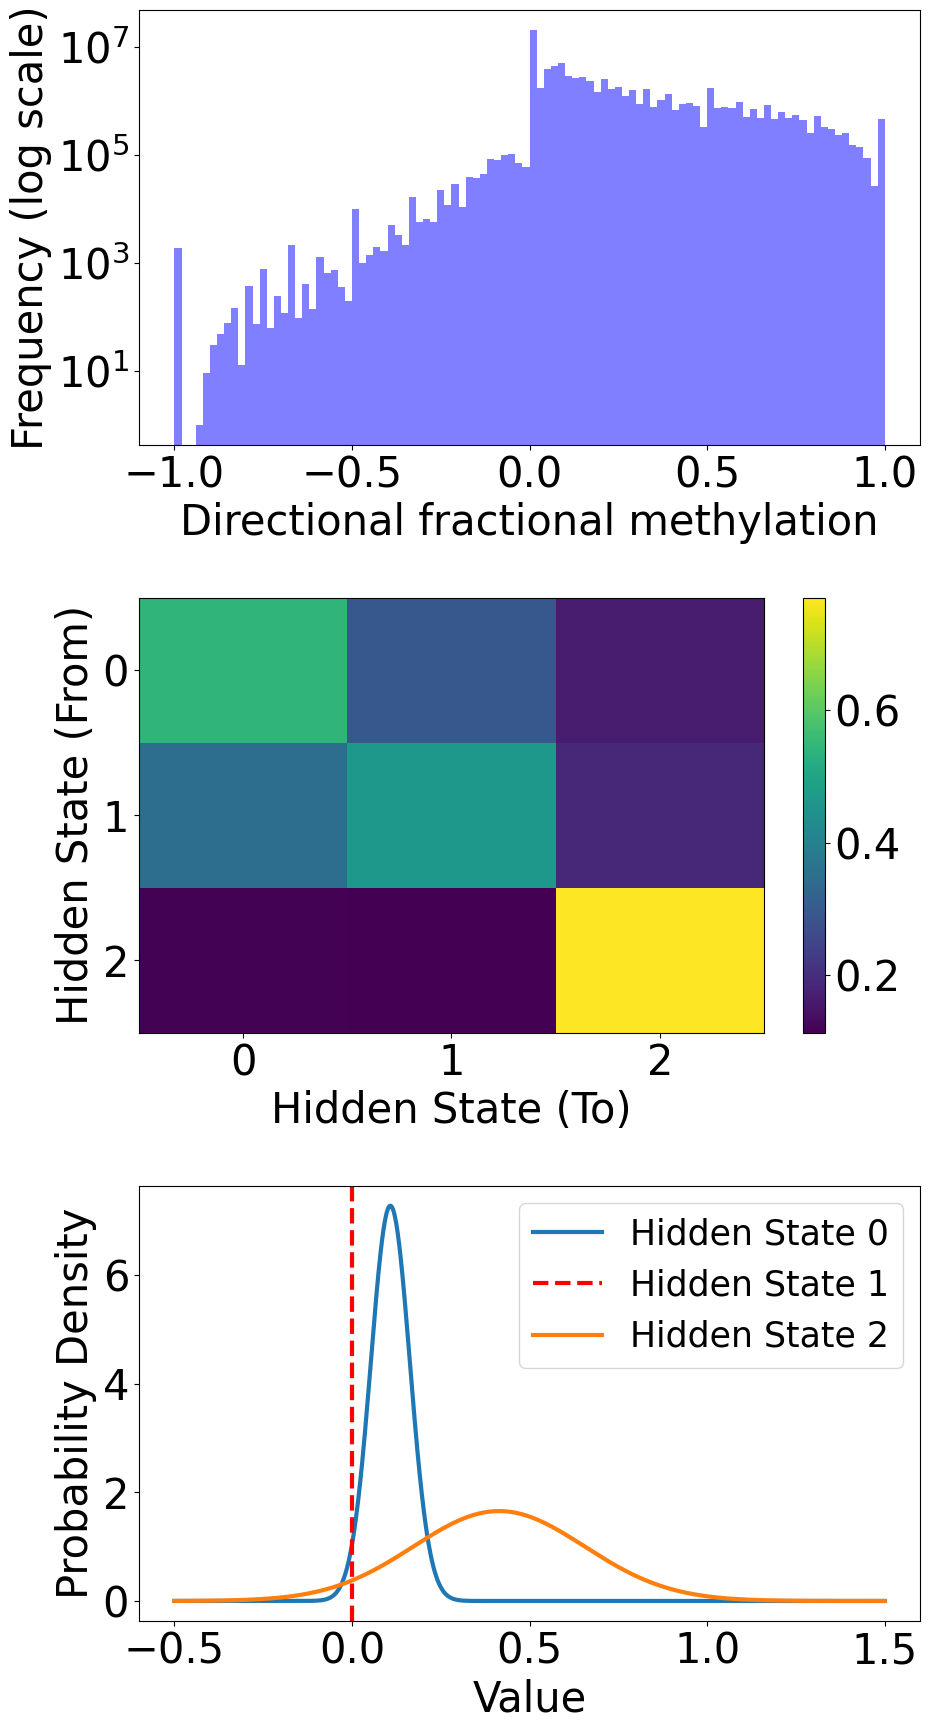

In [ ]:
save_dir = '/content/figures'
os.makedirs(save_dir, exist_ok=True)

# Create a figure with 3 vertical subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Define colors and line styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
linestyles = ['-', ':', '-.']
plt.rcParams.update({'font.size': 30, 'font.family': 'sans-serif'})  # Adjust the number to suit your needs

# Histogram plot
ax = axs[0]
ax.set_yscale('log')
ax.hist(seq_of_cpg_directional_fm, bins=100, alpha=0.5, color='blue')  # Adjust the number of bins and color
ax.set_xlabel('Directional fractional methylation')
ax.set_ylabel('Frequency (log scale)')
#ax.set_title('Histogram of CpG directional fractional methylation')

# Transition Matrix plot
ax = axs[1]
cax = ax.imshow(model.transmat_, aspect='auto')

# Create a colorbar with a reference to the imshow plot
fig.colorbar(cax, ax=ax)

# Set the title and labels
#ax.set_title('Transition Matrix for CpG directional FM', fontsize=22)
ax.set_xlabel('Hidden State (To)')
ax.set_ylabel('Hidden State (From)')
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
# box = ax.get_position()
# ax.set_position([box.x0 + 10, box.y0, box.width, box.height])

# Gaussian Distributions plot
ax = axs[2]
means = np.round(model.means_.flatten(), 3)
covariances = np.round(model.covars_.flatten(), 3)
x = np.linspace(-0.5, 1.5, 1000)

# Threshold for considering a covariance as very small
small_cov_threshold = 1e-10

# Plot each Gaussian
for index, (mean, cov) in enumerate(zip(means, covariances)):
    if cov < small_cov_threshold:
        # Plot as vertical bar
        ax.axvline(x=mean, color='red', linestyle='--', linewidth=3, label=f'Hidden State {index}')
    else:
        # Plot Gaussian
        ax.plot(x, norm.pdf(x, mean, np.sqrt(cov)), linewidth=3, label=f'Hidden State {index}')

#ax.set_title('Gaussian Distributions of HMM States')
ax.set_xlabel('Value')
ax.set_ylabel('Probability Density')
ax.legend(fontsize='small')

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.subplots_adjust(left=0.3, right=0.9, top=0.45, bottom=0.05, hspace=0.25)

# Save the figure
plt.savefig(os.path.join(save_dir, 'combined_plot.png'), format='png', dpi=1200)
files.download(os.path.join(save_dir, 'combined_plot.png'))

plt.show()

ML dataset: ml_250bp_db7e6e4
Number of rows: 16,358,081
Number of CpGs used in training the HMM: 81,542,064


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

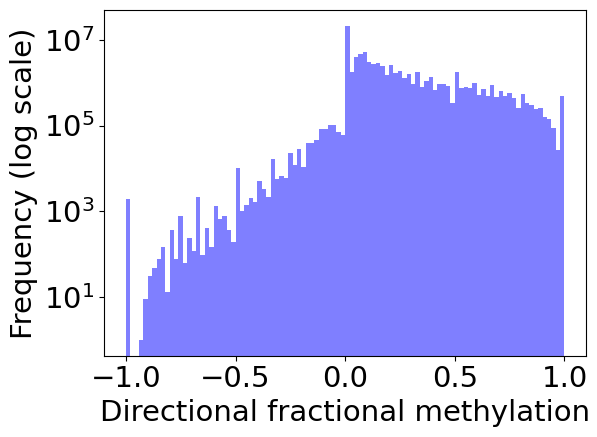

In [ ]:

for ml_dataset in ml_datasets:
  print(f"ML dataset: {ml_dataset}")
  query = f"""
      SELECT cpg_directional_fm
      FROM {project}.{ml_dataset}.features_wo_hmm
      WHERE cpg_directional_fm IS NOT NULL AND
        sample IN ({formatted_train_sample_list})
      --LIMIT 10000
      """

  cpg_direc_fm = bq_client.query(query).to_dataframe()

  cpg_direc_fm['cpg_directional_fm'] = cpg_direc_fm['cpg_directional_fm'].apply(lambda x: ast.literal_eval(x.strip('"')))

  print(f"Number of rows: {len(cpg_direc_fm):,}")

  seq_of_cpg_directional_fm = np.concatenate(
          cpg_direc_fm['cpg_directional_fm'].tolist()
      )

  print(f"Number of CpGs used in training the HMM: {len(seq_of_cpg_directional_fm):,}")

  plt.rcParams.update({'font.size': 21, 'font.family': 'sans-serif'})  # Adjust the number to suit your needs
  plt.yscale('log')
  plt.hist(seq_of_cpg_directional_fm, bins=100, alpha=0.5, color='blue')  # You can adjust the number of bins and color
  #plt.title('Histogram of CpG directional fractional methylation')
  plt.xlabel('Directional fractional methylation')
  plt.ylabel('Frequency (log scale)')
  plt.tight_layout()
  save_path = os.path.join(save_dir, f'{ml_dataset}_CpG_dir_frac_methyl.png')
  plt.savefig(save_path, format='png', dpi=1200)  # Increase dpi for higher resolution
  files.download(save_path)
  plt.show()

In [ ]:
#plt.savefig('/content/test', format='png', dpi=600)  # Increase dpi for higher resolution
!ls /content/figures


ml_250bp_db7e6e4_CpG_dir_frac_methyl_2.png


## Plot a few regions with and without ASM

In [ ]:
label_var = 'asm_not_corrected'

In [ ]:
query = f"""
      SELECT *
      FROM {project}.{ml_dataset}.TRAINING
      WHERE {label_var} IS NOT NULL AND cpg_directional_fm IS NOT NULL
      """
df = bq_client.query(query).to_dataframe()

# Convert list of strings
df['cpgs_w_padding'] = df['cpgs_w_padding'].apply(lambda x: ast.literal_eval(x.strip('"')))
df['cpg_directional_fm'] = df['cpg_directional_fm'].apply(lambda x: ast.literal_eval(x.strip('"')))

NotFound: 404 Not found: Table hmh-em-deepasm:ml_250bp_4.TRAINING was not found in location us-east1; reason: notFound, message: Not found: Table hmh-em-deepasm:ml_250bp_4.TRAINING was not found in location us-east1

Location: us-east1
Job ID: 7330db3e-8ac1-4972-b3fe-cc8d8824bf33


In [ ]:
df.iloc[0]['cpgs_w_padding']

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
# Identify strongest correlations

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove(label_var)

# Step 2: Calculate correlation of 'asm_snp' with other numerical columns
correlation_series = df[numerical_cols + [label_var]].corr()[label_var].drop(label_var)

# Step 3: Sort by absolute correlation values to identify strongest correlations
strongest_correlations = correlation_series.abs().sort_values(ascending=False)

# Display the sorted correlations
display(strongest_correlations[0:20])

count_state_4                           0.225361
mean_duration_state_4                   0.222455
transition_from_9_to_4                  0.214896
transition_probability_from_9_to_4      0.209962
cpg_fm_kd_5                             0.199825
proportion_state_4                      0.194141
cpg_fm_kd_4                             0.192455
proportion_state_13                     0.184953
mean_duration_state_13                  0.183918
count_state_9                           0.173822
transition_from_12_to_9                 0.171463
transition_probability_from_12_to_9     0.170840
cpg_fm_kd_6                             0.165750
transition_from_4_to_15                 0.164892
transition_probability_from_4_to_15     0.163776
mean_duration_state_9                   0.163030
transition_probability_from_12_to_13    0.162895
std_read_fm                             0.160394
transition_from_4_to_11                 0.155711
mean_duration_state_11                  0.155225
Name: asm, dtype: fl

Text(0.5, 0.98, 'Regions without ASM')

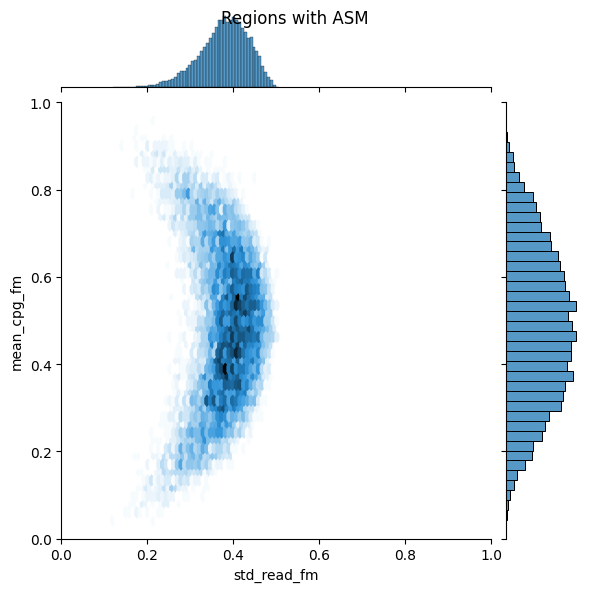

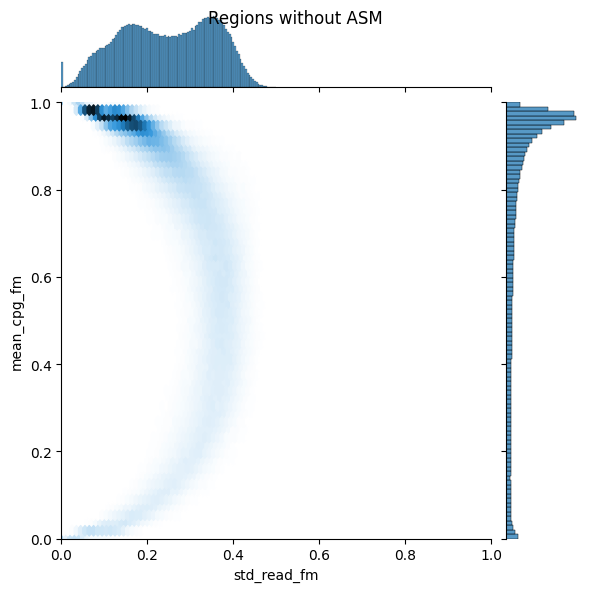

In [ ]:
pos_df = df[df[label_var] ==1].copy(deep = True)
neg_df = df[df[label_var] ==0].copy(deep = True)

var_x = 'std_read_fm' # transition_from_4_to_4 std_read_fm
var_y = 'mean_cpg_fm' # mean_cpg_fm

sns.jointplot(x=var_x, y=var_y, data=pos_df,
              kind='hex', xlim=(0, 1), ylim=(0, 1))
plt.suptitle("Regions with ASM")

sns.jointplot(x=var_x, y=var_y, data=neg_df,
              kind='hex', xlim=(0, 1), ylim=(0, 1))
plt.suptitle("Regions without ASM")

# plt.savefig("with_ASM.png", dpi = 600)
# files.download("with_ASM.png")


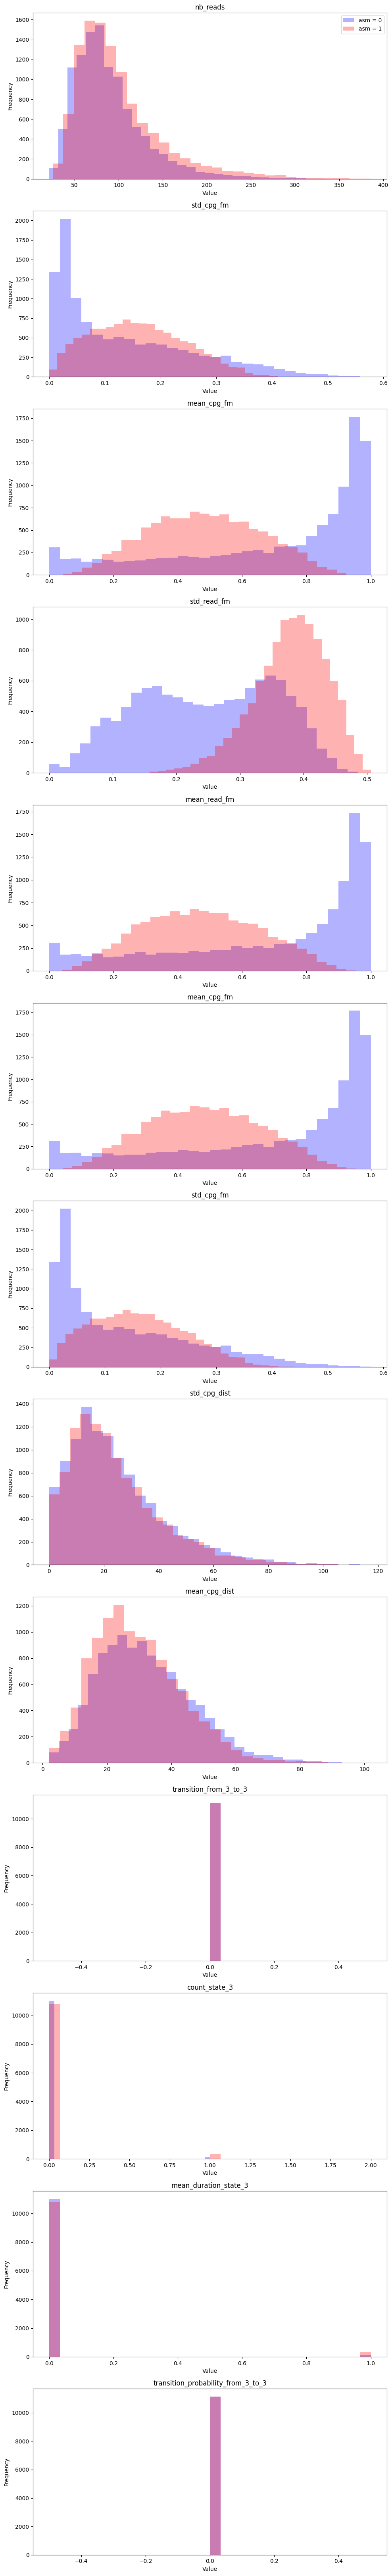

In [ ]:
plot_balanced_overlayed_distributions(df,
                                       ['nb_reads',
                                       'std_cpg_fm',
                                       'mean_cpg_fm',
                                       'std_read_fm',
                                       'mean_read_fm',
                                        'mean_cpg_fm',
                                        'std_cpg_fm',
                                       'std_cpg_dist',
                                       'mean_cpg_dist',
                                        'transition_from_3_to_3',
                                        'count_state_3',
                                        'mean_duration_state_3',
                                        'transition_probability_from_3_to_3'

                                       ])

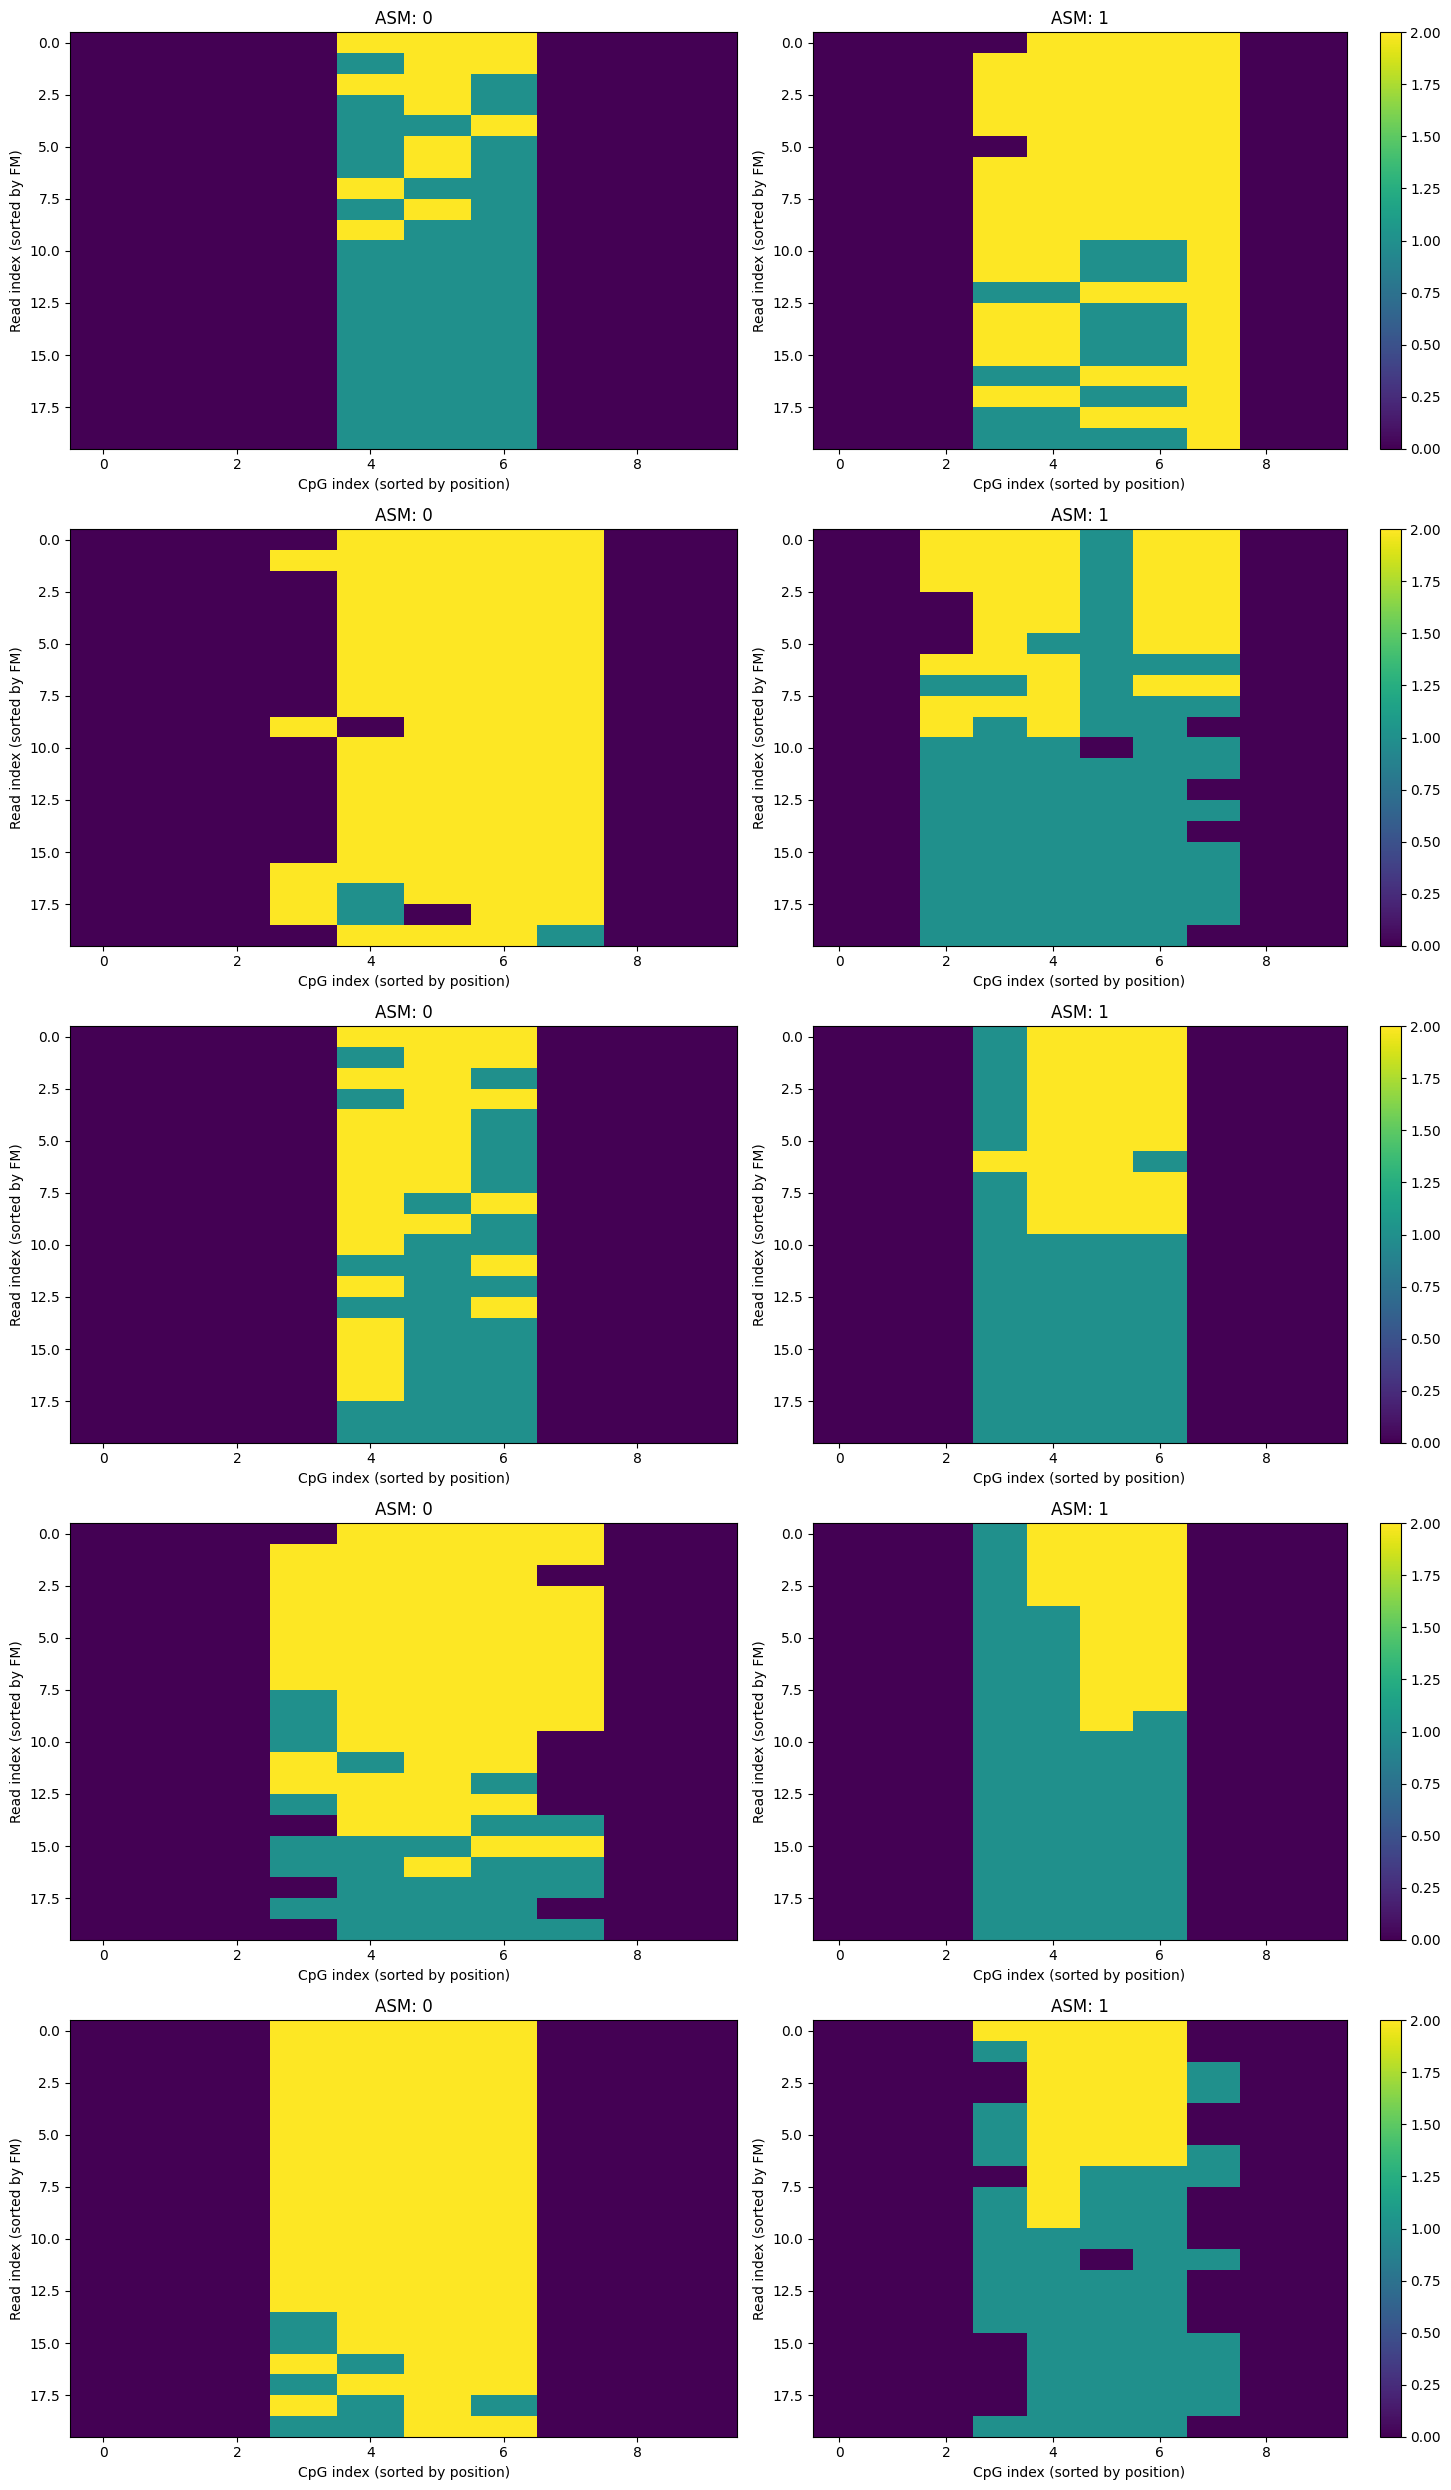

In [ ]:
plot_cpg_regions_from_df(df, 'cpgs_w_padding', 'asm', 5)


## Explore other distributions for HMM hidden states

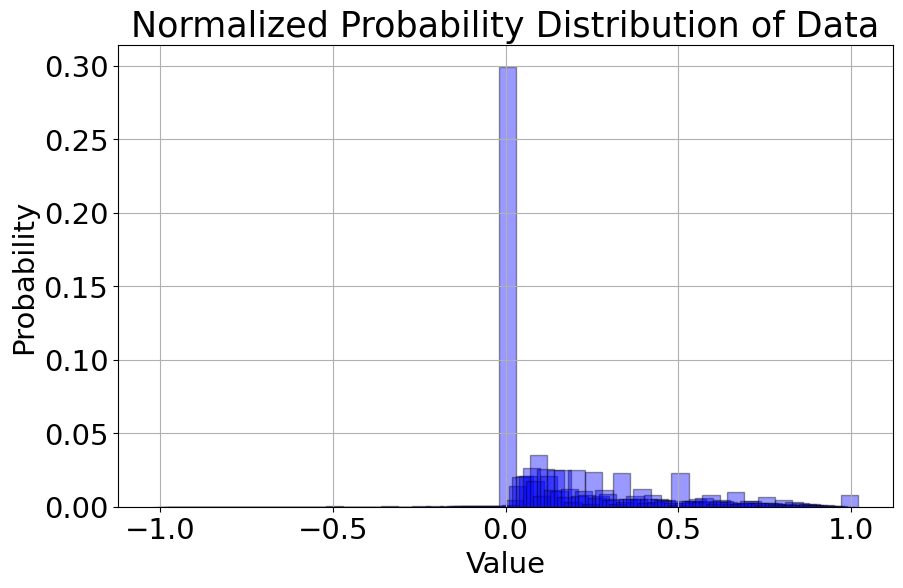

Sum of probabilities: 0.9999999999999999


In [ ]:
# Define the number of bins
num_bins = 200

# Create a histogram of the data
counts, bin_edges = np.histogram(seq_of_cpg_directional_fm, bins=num_bins, range=(-1, 1))

# Normalize the counts to get probabilities
probabilities = counts / counts.sum()

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the probability distribution
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, probabilities, width=0.05, align='center', alpha=0.4, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Normalized Probability Distribution of Data')
plt.grid(True)
plt.show()

# Verify that the sum of probabilities is 1
print(f"Sum of probabilities: {probabilities.sum()}")

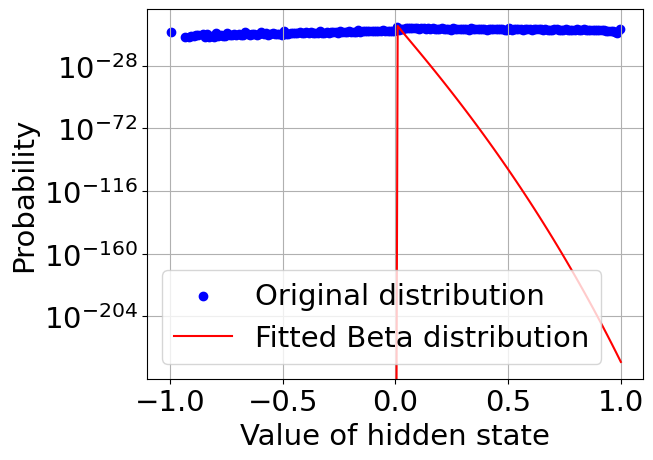

In [ ]:
from scipy.stats import norm
from scipy.stats import beta
# total_counts = sum(probabilities)
# probabilities = {key: value / total_counts for key, value in frequency.items()}
# keys = np.array(list(probabilities.keys()))
# prob_values = np.array(list(probabilities.values()))

alpha, beta_fit, loc, scale = beta.fit(probabilities)
mean = np.sum(bin_centers * probabilities)
variance = np.sum((bin_centers - mean)**2 * probabilities)
std_dev = np.sqrt(variance)

# Convert keys to an ordered list and sort them
#keys = sorted(list(probabilities.keys()))

# Plot the histogram of probabilities
#plt.bar(keys, [probabilities[key] for key in keys], color='blue', alpha=0.1, label='Normalized Frequencies')


# Plot the fitted beta distribution
x = np.linspace(-1, 1, 100)
plt.yscale('log')
plt.scatter(bin_centers, probabilities, color = 'blue', label='Original distribution')
beta_fitted = beta.pdf(x, alpha, beta_fit, loc, scale)
pdf_fitted = norm.pdf(x, loc=mean, scale=std_dev)
#plt.plot(x, pdf_fitted, 'r-', label='Fitted Gaussian distribution')

plt.plot(x, beta_fitted, 'r-', label='Fitted Beta distribution')

plt.xlabel('Value of hidden state')
plt.ylabel('Probability')
#plt.title('Beta Distribution Fitted to Counter Distribution')
plt.legend()
plt.grid(True)
plt.show()

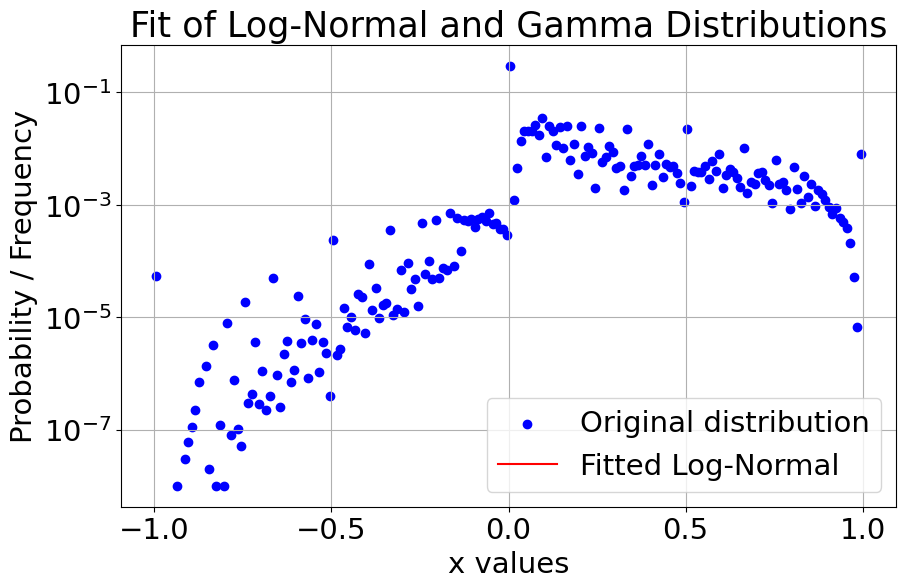

In [ ]:
from scipy.stats import lognorm, gamma, beta
from scipy.optimize import curve_fit



# Example data
# x = np.array([...])  # your x-values
# y = np.array([...])  # your y-values, treated as frequencies


# To fit the distributions, we need to define a probability density function for each
def log_normal_pdf(x, s, scale):
    return lognorm.pdf(x, s, scale=scale)

def gamma_pdf(x, a, scale):
    return gamma.pdf(x, a, scale=scale)

# Curve fitting using the defined PDFs
params_log_normal, _ = curve_fit(log_normal_pdf, bin_centers, probabilities, p0=[1, np.mean(bin_centers)])
params_gamma, _ = curve_fit(gamma_pdf, bin_centers, probabilities, p0=[1, np.mean(bin_centers)])
alpha, beta_fit, loc, scale = beta.fit(probabilities)

x_values = np.linspace(min(bin_centers), max(bin_centers), 400)
fitted_log_normal = log_normal_pdf(x_values, *params_log_normal)
fitted_gamma = gamma_pdf(x_values, *params_gamma)
beta_fitted = beta.pdf(x_values, alpha, beta_fit, loc, scale)


# Plotting the results
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.scatter(bin_centers, probabilities, color='blue', label='Original distribution')
plt.plot(x_values, fitted_log_normal, 'r-', label='Fitted Log-Normal')
#plt.plot(x_values, beta_fitted, 'g-', label='Fitted Beta')
#plt.plot(x_values, fitted_gamma, 'b-', label='Fitted Gamma')

plt.title('Fit of Log-Normal and Gamma Distributions')
plt.xlabel('x values')
plt.ylabel('Probability / Frequency')
plt.legend()
plt.grid(True)
plt.show()

## HMM model structure

Blob samples_250bp/models/VariationalGaussianHMM_3states_full_80893cb_ml_250bp_db7e6e4_PRODUCTION.joblib downloaded to /hmh_model.joblib.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

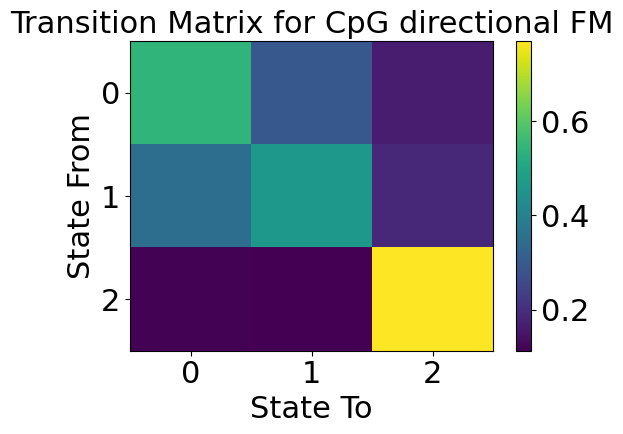

In [ ]:
# plt.rcParams.update({'font.size': 22})  # Adjust the number to suit your needs

# # Assuming best_model.transmat_ is defined and contains the transition matrix you want to plot
# # Create the figure and axis
# fig, ax = plt.subplots()

# # Plot the transition matrix
# cax = ax.imshow(model.transmat_, aspect='auto')

# # Create a colorbar with a reference to the imshow plot
# fig.colorbar(cax)

# # Set the title and labels
# ax.set_title('Transition Matrix between hidden states', fontsize = 20)
# ax.set_xlabel('State To')
# ax.set_ylabel('State From')
# plt.tight_layout()
# save_path = os.path.join(save_dir, f'{ml_dataset}_transition.png')
# plt.savefig(save_path, format='png', dpi=1200)  # Increase dpi for higher resolution
# files.download(save_path)
# # Display the plot
# plt.show()


Start probabilities:
[0.66473223 0.16666667 0.1686011 ]

Transition matrix:
[[0.54231137 0.29433809 0.16335054]
 [0.34997389 0.46416176 0.18586435]
 [0.11756009 0.112549   0.76989091]]

Gaussian distribution covariances:
[[[3.04721442e-03]]

 [[1.63937139e-08]]

 [[5.76605467e-02]]]

Gaussian means:
[[1.08352256e-01]
 [7.58608423e-08]
 [4.14220152e-01]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

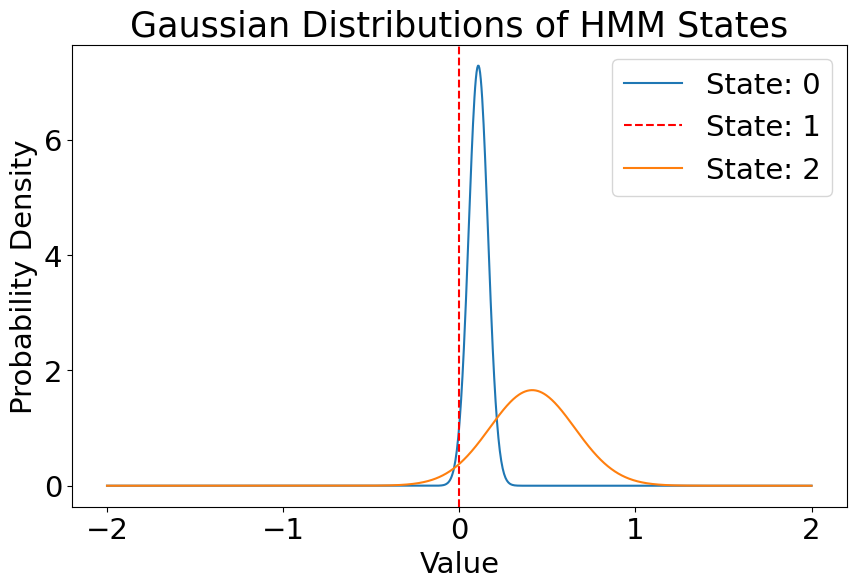

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example Gaussian parameters for 5 states
means = np.round(model.means_.flatten(), 3)  # [1, 3, 5, 7, 9]
covariances = np.round(model.covars_.flatten(), 3)  # [0.5, 0.2, 1.0, 0.3, 0.7]  # Variance in this case

# Create a figure
plt.figure(figsize=(10, 6))

# Value range for x-axis
x = np.linspace(-2, 2, 1000)

# Threshold for considering a covariance as very small
small_cov_threshold = 1e-10

# Plot each Gaussian
for index, (mean, cov) in enumerate(zip(means, covariances)):
    if cov < small_cov_threshold:
        # Plot as vertical bar
        plt.axvline(x=mean, color='red', linestyle='--', label=f'State: {index}')
    else:
        # Plot Gaussian
        plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), alpha = 1, label=f'State: {index}')

plt.title('Gaussian Distributions of HMM States')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
save_path = os.path.join(save_dir, f'{ml_dataset}_distrib.png')
plt.savefig(save_path, format='png', dpi=1200)  # Increase dpi for higher resolution
files.download(save_path)

plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

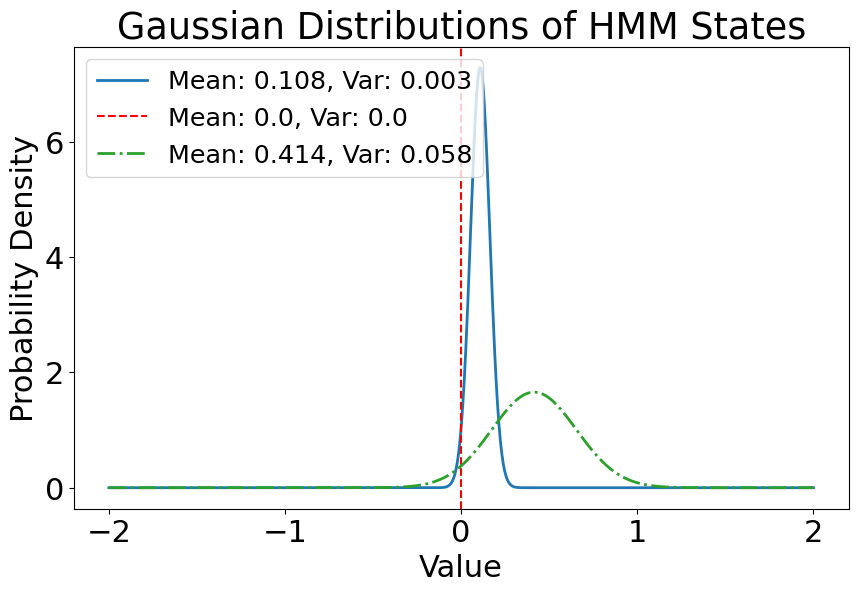

In [ ]:
plt.figure(figsize=(10, 6))
for mean, cov in zip(means, covariances):
    if cov < small_cov_threshold:
        # Plot as vertical bar
        plt.axvline(x=mean, color='red', linestyle='--', label=f'Mean: {mean}, Var: {cov}')
    else:
        # Plot Gaussian with different patterns and modern colors
        if cov == covariances[0]:  # Example for the first covariance
            plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), color='#1f77b4', linestyle='-', linewidth=2, label=f'Mean: {mean}, Var: {cov}')  # Blue
        elif cov == covariances[1]:  # Example for the second covariance
            plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), color='#ff7f0e', linestyle=':', linewidth=2, label=f'Mean: {mean}, Var: {cov}')  # Orange
        elif cov == covariances[2]:  # Example for the third covariance
            plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), color='#2ca02c', linestyle='-.', linewidth=2, label=f'Mean: {mean}, Var: {cov}')  # Green

plt.title('Gaussian Distributions of HMM States')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend(loc = 'upper left', fontsize = 'small')
save_path = os.path.join(save_dir, f'{ml_dataset}_distrib.png')
plt.savefig(save_path, format='png', dpi=1200)  # Increase dpi for higher resolution
files.download(save_path)
plt.show()